In [1]:
# São Luís - Neural Network

import tensorflow
tensorflow.random.set_seed(42)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 6,4
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (6,4)})
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
df = pd.read_excel(r"SaoLuis_ML_Std.xls")
df.head()

,SPD,CV,Price_sd,Price_skewness,Price_kurtosis,Cartel_SL
0,-1.512210,-1.415126,-1.523575,0.530595,-0.372297,1
1,-1.590998,-1.423813,-1.531361,0.465319,-0.465210,1
2,-1.472599,-1.390720,-1.500943,0.277075,-0.523992,1
3,-1.891792,-1.794681,-1.874691,0.988610,-0.150930,1
4,-1.512210,-1.424056,-1.531331,-0.390301,-0.859725,1


In [3]:
# Predicting Cartel
# define X and y
X = df.drop("Cartel_SL",axis = 1)
y = df.Cartel_SL

In [4]:
# summarize the dataset
print(X.shape, y.shape)

(449, 5) (449,)


In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [6]:
# The neural network model

def create_model(lyrs=[5], act='linear', opt='Adam', dr=0.0):
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [7]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
val_accuracy = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 79.48%


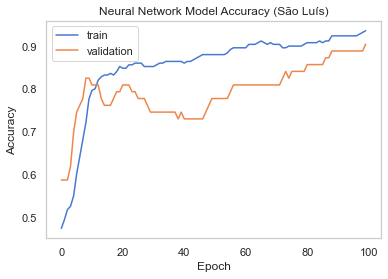

In [9]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Neural Network Model Accuracy (São Luís)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.grid(False)
plt.show()

In [10]:
# Grid search for the batch size and epochs

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [4, 8, 16, 32, 64]
epochs = [25, 50, 75, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)  
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [11]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.961813 using {'batch_size': 4, 'epochs': 100}
0.856624 (0.027312) with: {'batch_size': 4, 'epochs': 25}
0.901099 (0.040565) with: {'batch_size': 4, 'epochs': 50}
0.952228 (0.023329) with: {'batch_size': 4, 'epochs': 75}
0.961813 (0.020532) with: {'batch_size': 4, 'epochs': 100}
0.760867 (0.102568) with: {'batch_size': 8, 'epochs': 25}
0.789652 (0.049377) with: {'batch_size': 8, 'epochs': 50}
0.936294 (0.035085) with: {'batch_size': 8, 'epochs': 75}
0.952259 (0.013383) with: {'batch_size': 8, 'epochs': 100}
0.732295 (0.062692) with: {'batch_size': 16, 'epochs': 25}
0.741789 (0.055929) with: {'batch_size': 16, 'epochs': 50}
0.888614 (0.029205) with: {'batch_size': 16, 'epochs': 75}
0.875702 (0.021252) with: {'batch_size': 16, 'epochs': 100}
0.751435 (0.055271) with: {'batch_size': 32, 'epochs': 25}
0.744963 (0.058799) with: {'batch_size': 32, 'epochs': 50}
0.764042 (0.100917) with: {'batch_size': 32, 'epochs': 75}
0.789560 (0.089116) with: {'batch_size': 32, 'epochs': 100}
0.4533

In [12]:
# optimization Algorithm 

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=4, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [13]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.971377 using {'opt': 'SGD'}
0.971377 (0.018476) with: {'opt': 'SGD'}
0.961854 (0.016117) with: {'opt': 'RMSprop'}
0.547773 (0.075460) with: {'opt': 'Adagrad'}
0.395136 (0.086622) with: {'opt': 'Adadelta'}
0.968203 (0.017342) with: {'opt': 'Adam'}
0.961854 (0.016117) with: {'opt': 'Nadam'}


In [14]:
#Hidden neurons

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=100, batch_size=4, verbose=0)

# define the grid search parameters
layers = [(6,),(6, 4), (6, 4, 2)]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[CV] END ..........................................lyrs=(6,); total time=   3.3s
[CV] END ..........................................lyrs=(6,); total time=   3.3s
[CV] END ..........................................lyrs=(6,); total time=   3.6s
[CV] END ..........................................lyrs=(6,); total time=   3.4s
[CV] END ..........................................lyrs=(6,); total time=   2.8s
[CV] END ........................................lyrs=(6, 4); total time=   3.8s
[CV] END ........................................lyrs=(6, 4); total time=   4.1s
[CV] END ..............................

In [15]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.993600 using {'lyrs': (6, 4, 2)}
0.961854 (0.016117) with: {'lyrs': (6,)}
0.990425 (0.007819) with: {'lyrs': (6, 4)}
0.993600 (0.007839) with: {'lyrs': (6, 4, 2)}


In [16]:
#Dropout

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=100, batch_size=4, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', verbose=2)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............................................dr=0.0; total time=   3.3s
[CV] END .............................................dr=0.0; total time=   3.4s
[CV] END .............................................dr=0.0; total time=   3.5s
[CV] END .............................................dr=0.0; total time=   3.4s
[CV] END .............................................dr=0.0; total time=   3.0s
[CV] END ............................................dr=0.01; total time=   3.5s
[CV] END ............................................dr=0.01; total time=   3.5s
[CV] END ............................................dr=0.01; total time=   3.4s
[CV] END ............................................dr=0.01; total time=   3.9s
[CV] END ............................................dr=0.01; total time=   3.6s
[CV] END ............................................dr=0.05; total time=   3.8s
[CV] END ........................................

In [17]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.965028 using {'dr': 0.2}
0.961854 (0.016117) with: {'dr': 0.0}
0.961854 (0.016117) with: {'dr': 0.01}
0.961854 (0.016117) with: {'dr': 0.05}
0.961854 (0.016117) with: {'dr': 0.1}
0.965028 (0.015490) with: {'dr': 0.2}
0.949002 (0.015724) with: {'dr': 0.5}


In [18]:
# create final model
model = create_model(lyrs=[6,4, 2], dr=0.2)

print(model.summary())

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 6)                 36        
_________________________________________________________________
dense_118 (Dense)            (None, 4)                 28        
_________________________________________________________________
dense_119 (Dense)            (None, 2)                 10        
_________________________________________________________________
dropout_50 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 3         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=100, batch_size=4, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10/10 [==============================] - 0s 795us/step - loss: 0.0124 - accuracy: 1.0000

accuracy: 100.00%


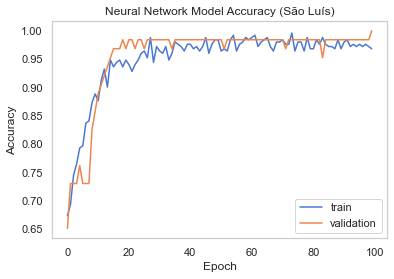

In [20]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Neural Network Model Accuracy (São Luís)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.grid(False)
plt.show()

In [21]:
# make class predictions for the testing set
model = create_model()
model.fit(X_test, y_test,
          batch_size=4,
          epochs=100,
          shuffle=True)
y_pred = model.predict(X_test)

Epoch 1/100
34/34 [==============================] - 0s 941us/step - loss: 0.6545 - accuracy: 0.6296
Epoch 2/100
34/34 [==============================] - 0s 704us/step - loss: 0.5994 - accuracy: 0.6741
Epoch 3/100
34/34 [==============================] - 0s 704us/step - loss: 0.5575 - accuracy: 0.7778
Epoch 4/100
34/34 [==============================] - 0s 705us/step - loss: 0.5264 - accuracy: 0.8074
Epoch 5/100
34/34 [==============================] - 0s 940us/step - loss: 0.5061 - accuracy: 0.7926
Epoch 6/100
34/34 [==============================] - 0s 706us/step - loss: 0.4868 - accuracy: 0.8222
Epoch 7/100
34/34 [==============================] - 0s 705us/step - loss: 0.4736 - accuracy: 0.8296
Epoch 8/100
34/34 [==============================] - 0s 705us/step - loss: 0.4637 - accuracy: 0.8296
Epoch 9/100
34/34 [==============================] - 0s 705us/step - loss: 0.4544 - accuracy: 0.8296
Epoch 10/100
34/34 [==============================] - 0s 706us/step - loss: 0.4476 - accura

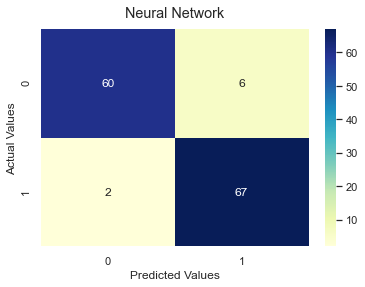

In [22]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred.round())
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
sns.set(font_scale=1.2) # Adjust to fit
plt.title('Neural Network', y=1.025)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('CM_NeuralNetwork_SaoLuis.png', dpi=600)

In [23]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        66
           1       0.92      0.97      0.94        69

    accuracy                           0.94       135
   macro avg       0.94      0.94      0.94       135
weighted avg       0.94      0.94      0.94       135



In [24]:
from sklearn.metrics import roc_curve
y_pred_proba = model.predict(X_test)[:,0]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

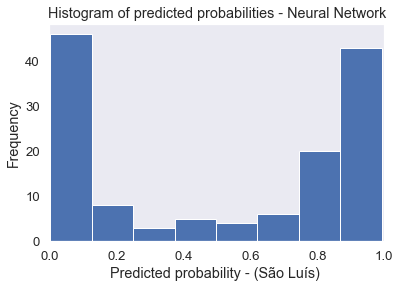

In [25]:
# histogram of predicted probabilities
plt.hist(y_pred_proba, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities - Neural Network')
plt.xlabel('Predicted probability - (São Luís) ')
plt.ylabel('Frequency')
plt.grid(False)
plt.savefig('Histogram_NeuralNetwork_SaoLuis.png', dpi=600)

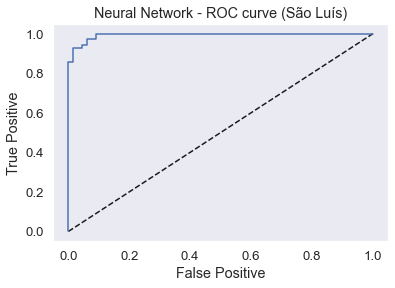

In [26]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Neural Network - ROC curve (São Luís)')
plt.grid(False)
sns.set_style("ticks")
plt.savefig('ROC_NeuralNetwork_SaoLuis.png', dpi=600)

In [27]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.9938515590689504

In [28]:
import eli5
from eli5.sklearn import PermutationImportance
# max error measures the classification Error: Overall, how often is the classifier incorrect?
perm = PermutationImportance(model, scoring='max_error', random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1939 ± 0.0000,Price_sd
0.1935 ± 0.0012,CV
0.1931 ± 0.0009,SPD
0.0405 ± 0.1220,Price_skewness
-0.0404 ± 0.0581,Price_kurtosis


Feature: 0, Score: 0.19188
Feature: 1, Score: 0.19377
Feature: 2, Score: 0.19387
Feature: 3, Score: 0.03156
Feature: 4, Score: -0.06277


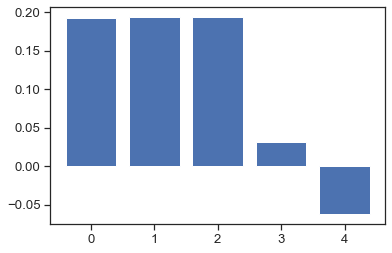

In [29]:
# perform permutation importance
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

results = permutation_importance(model, X_test, y_test, scoring='max_error',  n_repeats=100, random_state=1)
# max error measures the classification Error: Overall, how often is the classifier incorrect?
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#Feature 0: SPD
#Feature 1: CV
#Feature 2: Price_sd
#Feature 3: Price_skewness
#Feature 4: Price_kurtosis

In [30]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Especificity:', 1 - fpr[thresholds > threshold][-1])

In [31]:
evaluate_threshold(0.5)

Sensitividade: 0.9710144927536232
Especificidade: 0.9090909090909091


In [32]:
evaluate_threshold(0.6)

Sensitividade: 0.9710144927536232
Especificidade: 0.9393939393939394


In [33]:
evaluate_threshold(0.7)

Sensitividade: 0.927536231884058
Especificidade: 0.9545454545454546


In [34]:
evaluate_threshold(0.8)

Sensitividade: 0.855072463768116
Especificidade: 0.9848484848484849


In [35]:
evaluate_threshold(0.9)

Sensitividade: 0.014492753623188406
Especificidade: 1.0


In [36]:
evaluate_threshold(0.99)

Sensitividade: 0.014492753623188406
Especificidade: 1.0
